In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pcmcirustpy  # Ensure this is installed and available


# -------------------------------
# 1. Synthetic Data Generator
# -------------------------------

def generate_synthetic_data(n_time, n_vars, max_lag, causal_structure, noise_level=0.1, seed=42):
    np.random.seed(seed)
    burn_in = 100
    data = np.zeros((n_time + burn_in, n_vars))
    data[:max_lag] = np.random.rand(max_lag, n_vars)
    
    for t in range(max_lag, n_time + burn_in):
        for target_var in range(n_vars):
            value = 0.0
            if target_var in causal_structure:
                for source_var, lag, coeff in causal_structure[target_var]:
                    value += coeff * data[t - lag, source_var]
            value += np.random.normal(0, noise_level)
            data[t, target_var] = value
            
    return data[burn_in:]


# -------------------------------
# 2. Run PCMCI (Tigramite)
# -------------------------------

def run_pcmci_tigramite(data, max_lag, alpha, max_condition_set_size, max_subsets):
    df = DataFrame(data, var_names=[f'var{i}' for i in range(data.shape[1])])
    pcmci = PCMCI(dataframe=df, cond_ind_test=ParCorr())
    
    start = time.time()
    results = pcmci.run_pcmci(
        tau_max=max_lag,
        pc_alpha=alpha,
        max_conds_dim=max_condition_set_size,
        max_combinations=max_subsets
    )
    end = time.time()
    
    return results, end - start


# -------------------------------
# 3. Run PCMCI (Rust)
# -------------------------------

def run_pcmci_rust(data, max_lag, alpha, max_condition_set_size, max_subsets):
    start = time.time()
    results = pcmcirustpy.run_pcmci(data, max_lag, alpha, max_condition_set_size, max_subsets)
    end = time.time()
    
    return results, end - start


# -------------------------------
# 4. Compare Results
# -------------------------------

import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

def calculate_difference_metrics(matrix1, matrix2):
    # Mask valid values
    valid_mask = ~np.isnan(matrix1) & ~np.isnan(matrix2)
    x = matrix1[valid_mask].flatten()
    y = matrix2[valid_mask].flatten()

    if x.size == 0:
        return {
            "mean_rel_error": np.nan,
            "cosine_similarity": np.nan,
            "pearson_corr": np.nan,
        }

    # Mean Relative Error (MAPE-like, symmetric)
    mean_rel_error = np.mean(np.abs(x - y) / (np.abs(x) + np.abs(y) + 1e-8))

    # Cosine similarity (1 = perfect match)
    cosine_similarity = 1 - cosine(x, y)

    # Pearson correlation (1 = perfect linear match)
    pearson_corr, _ = pearsonr(x, y)

    return {
        "mean_rel_error": mean_rel_error,
        "cosine_similarity": cosine_similarity,
        "pearson_corr": pearson_corr,
    }




# -------------------------------
# 5. Benchmark Runner
# -------------------------------

def benchmark_single_param(
    param_name,
    param_values,
    n_time,
    n_vars,
    causal_structure,
    noise_level,
    fixed_params
):
    """
    Benchmarks Tigramite and Rust PCMCI runtimes and differences over a range of a single parameter.

    Args:
        param_name (str): The name of the parameter to vary. One of: 'max_lag', 'alpha', 'cond_size', 'subsets'.
        param_values (list): Values of that parameter to iterate over.
        n_time (int): Time series length.
        n_vars (int): Number of variables.
        causal_structure (dict): Causal structure for synthetic data.
        noise_level (float): Noise level in synthetic data.
        fixed_params (dict): Other parameters (not varied) as a dictionary.

    Returns:
        pd.DataFrame: DataFrame of benchmark results.
    """
    tig_times = []
    rust_times = []
    diffs = []

    for val in param_values:
        # Set the dynamic parameter
        params = fixed_params.copy()
        params[param_name] = val

        data = generate_synthetic_data(n_time, n_vars, params["max_lag"], causal_structure, noise_level)

        result_tig, time_tig = run_pcmci_tigramite(data, params["max_lag"], params["alpha"],
                                                   params["cond_size"], params["subsets"])
        result_rust, time_rust = run_pcmci_rust(data, params["max_lag"], params["alpha"],
                                                params["cond_size"], params["subsets"])

        metrics = calculate_difference_metrics(result_tig["val_matrix"], result_rust["val_matrix"])

        tig_times.append(time_tig)
        rust_times.append(time_rust)
        diffs.append(metrics)

    df_results = pd.DataFrame({
        param_name: param_values,
        "time_tigramite": tig_times,
        "time_rust": rust_times,
        "mean_rel_error": [d["mean_rel_error"] for d in diffs],
        "cosine_similarity": [d["cosine_similarity"] for d in diffs],
        "pearson_corr": [d["pearson_corr"] for d in diffs]
    })

    return df_results


# -------------------------------
# 6. Plot Results
# -------------------------------

def plot_time_vs_param(df, param_name):
    plt.figure(figsize=(8, 5))
    plt.plot(df[param_name], df["time_tigramite"], label="Tigramite", marker='o')
    plt.plot(df[param_name], df["time_rust"], label="Rust", marker='x')
    plt.title(f"Execution Time vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/v_/fl81qss97cn719thmbb_30fc0000gp/T/ipykernel_22045/3188803053.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlGn")


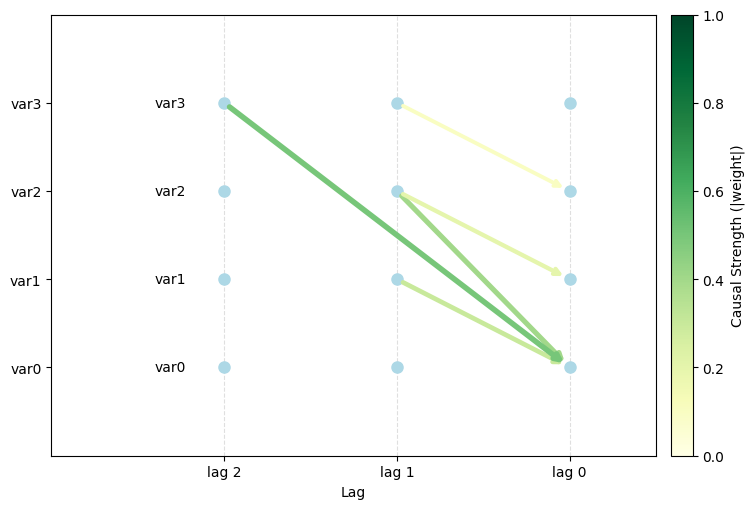

In [ ]:
causal_edges = [
    ("var1", "var0", 1, 0.3),
    ("var2", "var0", 1, 0.4),
    ("var3", "var0", 2, 0.5),
    ("var2", "var1", 1, 0.2),
    ("var3", "var2", 1, 0.1),
]

def build_causal_structure(edge_list, var_names):
    var_indices = {name: i for i, name in enumerate(var_names)}
    causal_structure = {}

    for src, tgt, lag, coeff in edge_list:
        tgt_idx = var_indices[tgt]
        src_idx = var_indices[src]

        if tgt_idx not in causal_structure:
            causal_structure[tgt_idx] = []
        causal_structure[tgt_idx].append((src_idx, lag, coeff))

    return causal_structure

import networkx as nx

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_lagged_causal_structure(edge_list, var_names=None, title="", max_lag=None):
    """
    Plots a time-unrolled causal graph with:
    - Variables on Y-axis (alphabetical)
    - Lags on X-axis (lag 0 = present)
    - Arrows color-coded by weight strength
    """
    if var_names is None:
        var_set = {src for src, *_ in edge_list} | {tgt for _, tgt, *_ in edge_list}
        var_names = sorted(var_set)

    var_indices = {v: i for i, v in enumerate(var_names)}
    n_vars = len(var_names)

    if max_lag is None:
        max_lag = max(lag for _, _, lag, _ in edge_list)

    fig, ax = plt.subplots(figsize=(3 * max_lag + 2, 0.8 * n_vars + 2))

    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap("YlGn")

    # Draw variable nodes
    for var, y in var_indices.items():
        for lag in range(max_lag + 1):
            ax.plot(lag, y, "o", color="lightblue", markersize=8)
        ax.text(max_lag + 0.4, y, var, va="center", fontsize=10)

    # Draw weighted, color-coded arrows
    for src, tgt, lag, weight in edge_list:
        src_y = var_indices[src]
        tgt_y = var_indices[tgt]

        color = cmap(norm(abs(weight)))
        linewidth = 2.5 + 3.0 * norm(abs(weight))  # Thickness scales with weight

        ax.annotate(
            "",
            xy=(0, tgt_y),
            xytext=(lag, src_y),
            arrowprops=dict(
                arrowstyle="->",
                lw=linewidth,
                color=color,
                shrinkA=5,
                shrinkB=5,
            ),
        )

    # Axis formatting
    ax.set_yticks(range(n_vars))
    ax.set_yticklabels(var_names)
    ax.set_xticks(range(max_lag + 1))
    ax.set_xticklabels([f"lag {l}" for l in range(max_lag + 1)])
    ax.set_xlim(-0.5, max_lag + 1)
    ax.set_ylim(-1, n_vars)
    ax.invert_xaxis()
    ax.set_xlabel("Lag")
    ax.set_title(title, fontsize=13, pad=12)
    ax.grid(True, axis='x', linestyle='--', alpha=0.4)

    # Optional: add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Causal Strength (|weight|)", rotation=90)

    plt.tight_layout()
    plt.show()



var_names = [f"var{i}" for i in range(4)]
causal_edges = [
    # (orig, dest, lag, weight)
    ("var1", "var0", 1, 0.3),
    ("var2", "var0", 1, 0.4),
    ("var3", "var0", 2, 0.5),
    ("var2", "var1", 1, 0.2),
    ("var3", "var2", 1, 0.1),
]

causal_structure = build_causal_structure(causal_edges, var_names)
plot_lagged_causal_structure(causal_edges)

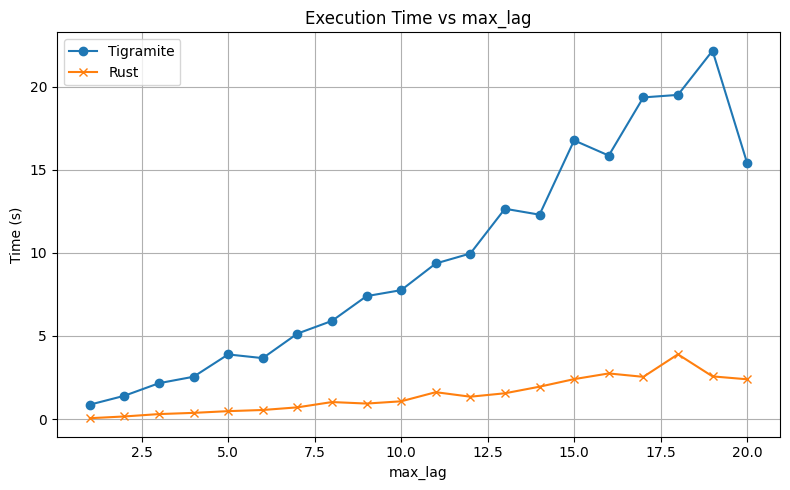

In [55]:
causal_structure = {
    0: [(1, 1, 0.3), (2, 1, 0.4), (3, 2, 0.5)],
    1: [(2, 1, 0.2)],
    2: [(3, 1, 0.1)],
}

fixed_params = {
    # "max_lag": 2,
    "alpha": 0.05,
    "cond_size": 3,
    "subsets": 1,
}

vary_lags = range(1,21)
df = benchmark_single_param("max_lag", vary_lags, n_time=100000, n_vars=5,
                            causal_structure=causal_structure, noise_level=0.05,
                            fixed_params=fixed_params)

plot_time_vs_param(df, "max_lag")

In [ ]:
# TODO: Use tqdm
# TODO: benchmark average times 5 runs

In [ ]:
# On average, each pair of corresponding elements in the two matrices differ by about x% of their combined magnitude.

In [56]:
df

,max_lag,time_tigramite,time_rust,mean_rel_error,cosine_similarity,pearson_corr
0,1,0.865619,0.050764,0.003034,0.999989,0.999975
1,2,1.401132,0.155879,0.027553,0.999996,0.999995
2,3,2.157937,0.299031,0.007754,0.999999,0.999999
3,4,2.546966,0.371968,0.000025,1.000000,1.000000
4,5,3.889795,0.475967,0.007612,0.999999,0.999999
5,6,3.667487,0.544991,0.006032,0.999999,0.999999
6,7,5.142010,0.704064,0.015294,0.999997,0.999996
7,8,5.908209,1.023048,0.029214,0.999992,0.999988
8,9,7.398983,0.932698,0.032150,0.999987,0.999986
9,10,7.759390,1.067879,0.004113,1.000000,1.000000
